In [1]:
!pip install numpy pandas matplotlib seaborn imbalanced-learn 

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels


# Understanding Songs on Spotify and their Emotional Impact (Final Project)
- We made sure that we read the file correctly and checked for various missing rows and null values. These were then removed. We made sure that we ensured that all the emotions were both recognized.

In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [3]:
df = pd.read_csv("spotifyregression.csv", usecols=['emotion', 'Popularity', 'Energy', 'Positiveness'], low_memory=False)

In [4]:
df.columns = df.columns.str.strip().str.lower()

In [5]:
print(f"Initial shape (rows, columns): {df.shape}")

Initial shape (rows, columns): (498087, 4)


In [6]:
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
emotion         35
popularity      36
energy          35
positiveness    36
dtype: int64


In [7]:
df = df.dropna(how='all')
df = df.dropna()

In [8]:
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
emotion         0
popularity      0
energy          0
positiveness    0
dtype: int64


In [9]:
print(f"Emotion categories: {df['emotion'].unique()}")

Emotion categories: ['sadness' 'joy' 'love' 'surprise' 'anger' 'fear' 'angry' 'TRUE'
 'Baby Mama'
 " and you's weak tryin' to point And if I take a style like freestyle And then I will be back in the meanwhile Go back cause if I ever catch you gettin' jacked They'll probably send you to the penile I'll snitch on some tricks"
 ' you have to vote for Barack Obama (Cheers'
 ' that don’t care Blazed by the shots and flares Girl c’mon'
 " I'll pass An act of self-preservation Sometimes you can fix something by just makin' it up Everything is fiction Sometimes you can fix something by just getting bought out If they can meet your stipulations Sometimes you can fix something by just having no mercy Total capitulation Sometimes you can fix something by just mnusy lkspek lknaoi Yeah"
 ' Bimaz & Benz"" (Universal) 36. Ol\' Dirty Bastard ""Shimmy Shimmy Ya"" (Elektra) 37. Jay-Z ""In My Lifetime""/""Can\'t Get wit That"" (Roc-a-Fella) 38. Three 6 Mafia ""Tear da Club Up (Da Real)"" (Prophet) 39. F

## Makign sure that the correct emotions were aligned and that they all were in the same case. We found that there were some duplicate emotions so we joind those together in the following pre-processing steps. 

In [10]:
allowed_emotions = ['sadness', 'joy', 'love', 'surprise', 'anger', 'fear', 'angry']
df = df[df['emotion'].str.lower().isin(allowed_emotions)]

In [11]:
print(f"\nNumber of unique emotions: {df['emotion'].nunique()}")
print(f"Emotion categories: {df['emotion'].unique()}")


Number of unique emotions: 8
Emotion categories: ['sadness' 'joy' 'love' 'surprise' 'anger' 'fear' 'angry' 'Love']


In [12]:
df['emotion'] = df['emotion'].str.lower()
df['emotion'] = df['emotion'].replace({'angry': 'anger'})

In [13]:
print(f"\nNumber of unique emotions: {df['emotion'].nunique()}")
print(f"Emotion categories: {df['emotion'].unique()}")


Number of unique emotions: 6
Emotion categories: ['sadness' 'joy' 'love' 'surprise' 'anger' 'fear']


In [14]:
print(df.select_dtypes(include='object').columns)

Index(['emotion', 'popularity', 'energy', 'positiveness'], dtype='object')


In [15]:
df.head(25)

,emotion,popularity,energy,positiveness
0,sadness,40,83,87
1,sadness,42,85,87
2,joy,29,89,63
3,joy,24,84,97
4,joy,30,71,70
5,love,26,81,74
6,sadness,17,89,65
7,joy,27,88,95
8,surprise,33,72,58
9,sadness,21,68,67


In [16]:
print(df.dtypes)

emotion         object
popularity      object
energy          object
positiveness    object
dtype: object


In [17]:
le = LabelEncoder()
df['emotion_encoded'] = le.fit_transform(df['emotion'])

In [18]:
print("\nSummary statistics:")
print(df[['popularity', 'energy', 'positiveness']].describe())


Summary statistics:
       popularity  energy positiveness
count      497996  497996       497996
unique        100     101          101
top            27      72           34
freq        13362    9650         8407


## Why Logistic Regression?
- We decided to use logistic regression because we were looking at trying to figure out a binary outcome. We wanted to check the models to see the probability that a song with certain specific features belonged to a specific emotion category (the 6 that we had). This is always good when working with one predicitor at a time. This helps us interpret features that relate to the likelihood of the emotion being predicted correctly. This also helps when trying to adjust for class imbalance. 

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import pandas as pd


variables = ['popularity', 'energy', 'positiveness']
results = []

for var in variables:
    X_single = df[[var]]

    for emotion_label in le.classes_:
        y_binary = (df['emotion'] == emotion_label).astype(int)

        X_train, X_test, y_train, y_test = train_test_split(X_single, y_binary, test_size=0.2, random_state=42)

        model = LogisticRegression(solver='liblinear', class_weight='balanced', max_iter=1000)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

        results.append({
            'feature': var,
            'emotion': emotion_label,
            'precision': report['1']['precision'],
            'recall': report['1']['recall'],
            'f1': report['1']['f1-score'],
            'accuracy': report['accuracy']
        })


metrics_df = pd.DataFrame(results)

print(metrics_df)


         feature   emotion  precision    recall        f1  accuracy
0     popularity     anger   0.196104  0.567685  0.291508  0.471355
1     popularity      fear   0.052049  0.545748  0.095035  0.450261
2     popularity       joy   0.387386  0.452025  0.417217  0.517952
3     popularity      love   0.052024  0.453082  0.093332  0.549779
4     popularity   sadness   0.314161  0.557240  0.401797  0.481215
5     popularity  surprise   0.009918  0.441767  0.019400  0.553414
6         energy     anger   0.209407  0.571196  0.306462  0.504719
7         energy      fear   0.054086  0.534358  0.098229  0.481074
8         energy       joy   0.386886  0.469779  0.424322  0.513414
9         energy      love   0.061595  0.521005  0.110166  0.569538
10        energy   sadness   0.319521  0.473684  0.381621  0.520030
11        energy  surprise   0.010397  0.481928  0.020355  0.536124
12  positiveness     anger   0.202904  0.508202  0.290017  0.523313
13  positiveness      fear   0.056547  0.543660 

## Thoughts
For my portion of the project, I was testing how well popularity, energy, and positiveness, can individually predict the emotion of the song using logistic regression. I used an 80/20 split in the data. I began by making sure that all the variables were all lowercase, to make them all uniform. As well, there was a little more pre-processing to remove any unnecessary data that I wouldn't need for my specific model testing.
### Popularity
Using only popularity as a predictor of emotion shows limited performance across the board. While it does provide some signal — like moderate recall for anger (0.568) and sadness (0.547) — the precision scores are quite low, often below 0.30. This means the model is frequently guessing incorrectly when it tries to predict a positive case. Emotions like joy, love, and surprise especially suffer from both low precision and F1-scores, suggesting that popularity on its own doesn’t carry enough emotional weight to make confident predictions. Overall, accuracy scores range from 0.45 to 0.55, which is slightly better.
### Energy
Energy slightly improves performance over popularity, especially for fear and joy. For example, fear has a recall of 0.681 and joy has a decent balance with a precision of 0.387 and F1-score of 0.424. This suggests that energy may be more directly connected to emotional intensity in music. However, surprise still performs poorly with a near-zero F1-score, and overall accuracy still hovers in the mid-50% range at best. So while energy gives us a slightly clearer signal than popularity, its far from reliable to determining the emotion of the song.
### Positiveness 
Positiveness gave the most consistent performance across the board. It showed slightly stronger precision and F1-scores for joy, love, and sadness. For instance, joy had a precision of 0.544 and F1 of 0.426. These results suggest that positiveness is more meaningfully tied to emotional content, especially when distinguishing the beat of the music that an individual is listening to. Emotions like anger and surprise still had weak scores. Accuracy scores again range from about 0.50–0.53, showing improvement but still not high enough for dependable prediction on its own.
### Summary
As we have seen, positiveness seems to show the best overall performance when predicting specific emotions in the songs of the data set. In second, Energy did okay but not as good as positiveness. Popularity really didn't show much predictive power with generally lower scores. We used a heatmap as well as bar graphs to help show the relationship between the 6 emotional characteristics and how the three variables we were testing worked in the modeling.

### Visualizations

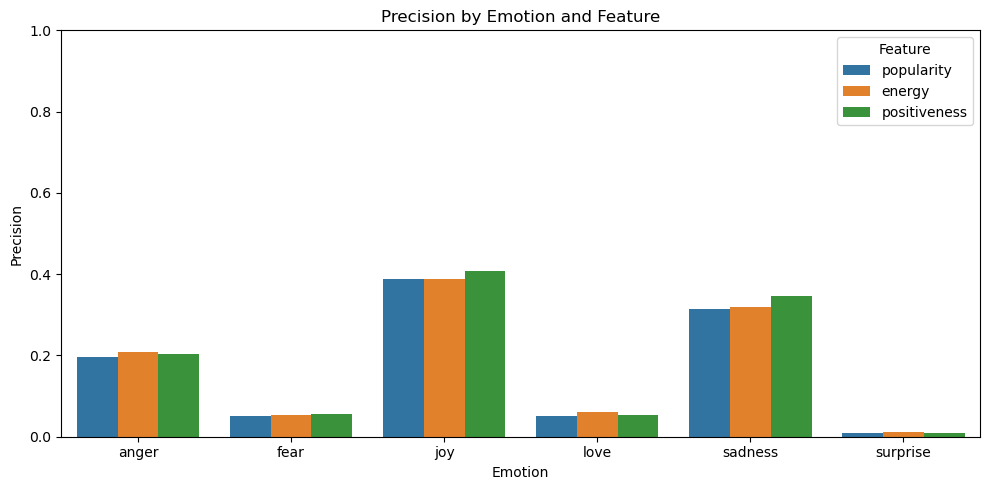

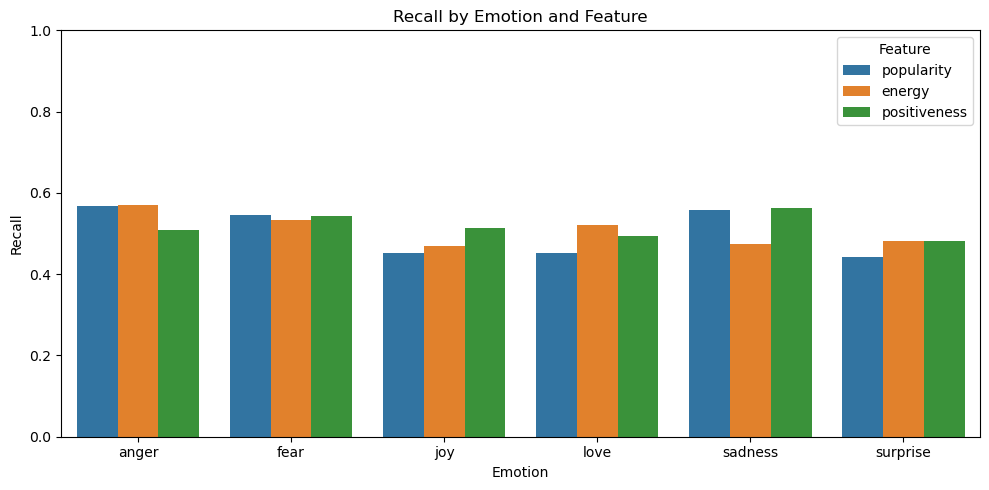

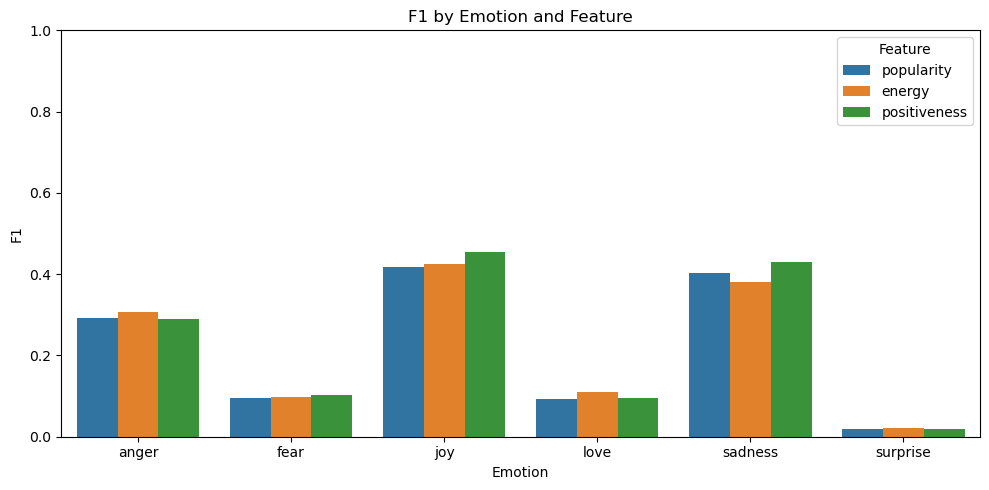

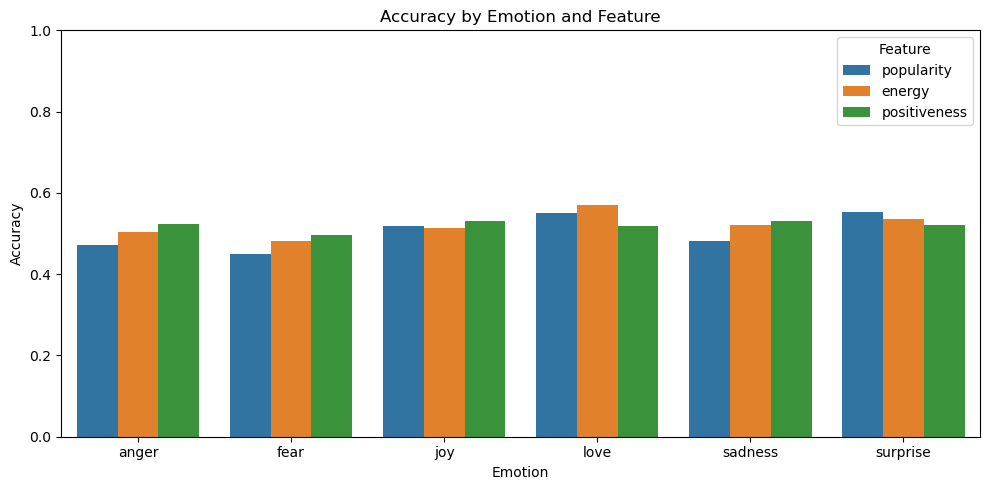

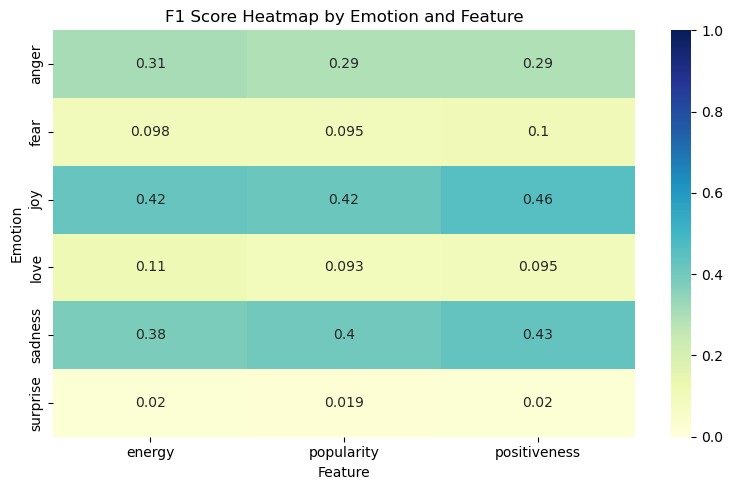

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns


for metric in ['precision', 'recall', 'f1', 'accuracy']:
    plt.figure(figsize=(10, 5))
    sns.barplot(data=metrics_df, x='emotion', y=metric, hue='feature')
    plt.title(f'{metric.capitalize()} by Emotion and Feature')
    plt.ylim(0, 1)
    plt.xlabel('Emotion')
    plt.ylabel(metric.capitalize())
    plt.legend(title='Feature')
    plt.tight_layout()
    plt.show()


heatmap_df = metrics_df.pivot(index='emotion', columns='feature', values='f1')

plt.figure(figsize=(8, 5))
sns.heatmap(heatmap_df, annot=True, cmap='YlGnBu', vmin=0, vmax=1)
plt.title('F1 Score Heatmap by Emotion and Feature')
plt.xlabel('Feature')
plt.ylabel('Emotion')
plt.tight_layout()
plt.show()

### Storytelling, Conclusion & Impact
For my portion of the project, this modeling was used to help understand how individual song features influence emotional content. One key take away is that positiveness was the most meaningful predictor out of the three variables tested. Popularity was last as it didnt tell us how much about the song "feels" to people. This makes sense because just because a song is upbeat or sad, wont really have an affect on how individuals relate emotion to it. We could improve the overall modeling by including more features instead of just using one in this logistic regression modeling. This could be done with for example Random Forests testing.
In terms of impact, this could be used by businesses to help improve mood-based music recommendations on their applications that will help individuals determine what songs they should listen to. This will help them build playlists more efficiently. However, I do believe that more testing needs to be happen before this all can be properly implemented in the real world. I think if we had more time, we could look into added more features and doing more complex modeling that brings in more variables to try and find key better variables to do during the testing. 